In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Read in Data
calls = pd.read_csv('../data/calls_by_district_and_time_segment_with_year.csv')
calls[['NAME', 'weekday', 'week_of_year', 'time_segment', 'year']].value_counts()

NAME        weekday    week_of_year  time_segment  year
SOUTH END   Friday     18            AFTERNOON_3   2018    12
FRIENDSHIP  Thursday   29            MORNING_4     2017     8
SOUTH END   Saturday   35            AFTERNOON_1   2024     8
            Friday     43            AFTERNOON_2   2024     8
FRIENDSHIP  Friday     37            AFTERNOON_3   2023     7
                                                           ..
ROUSS       Sunday     51            AFTERNOON_4   2020     1
                                                   2016     1
                                     AFTERNOON_3   2023     1
                                     AFTERNOON_2   2024     1
SOUTH END   Wednesday  53            MORNING_1     2020     1
Name: count, Length: 32400, dtype: int64

In [3]:
# Count calls per combo, keeping week_of_year as numeric
counts = (
    calls[['NAME', 'weekday', 'week_of_year', 'time_segment', 'year']]
    .value_counts()
    .reset_index(name='call_count')
)

# Get active year range per name
active_ranges = (
    calls
    .groupby('NAME')
    .agg(min_year=('year', 'min'), max_year=('year', 'max'))
    .reset_index()
)

# Build full grid of all combos
names = calls['NAME'].unique()
weekdays = calls['weekday'].unique()
weeks = calls['week_of_year'].unique()
segments = calls['time_segment'].unique()
years = calls['year'].unique()

full_grid = pd.MultiIndex.from_product(
    [names, weekdays, weeks, segments, years],
    names=['NAME', 'weekday', 'week_of_year', 'time_segment', 'year']
).to_frame(index=False)

# Filter grid to active periods only
full_grid = full_grid.merge(active_ranges, on='NAME', how='left')
full_grid = full_grid[
    (full_grid['year'] >= full_grid['min_year']) &
    (full_grid['year'] <= full_grid['max_year'])
    ].drop(columns=['min_year', 'max_year'])

# Merge with actual counts
counts_full = full_grid.merge(
    counts,
    on=['NAME', 'weekday', 'week_of_year', 'time_segment', 'year'],
    how='left'
)

# Fill missing counts with 0
counts_full['call_count'] = counts_full['call_count'].fillna(0).astype(int)

# Add cyclical encoding for week_of_year so that last day of year matches with first day of year
counts_full['week_of_year_sin'] = np.sin(2 * np.pi * counts_full['week_of_year'] / 53.0)
counts_full['week_of_year_cos'] = np.cos(2 * np.pi * counts_full['week_of_year'] / 53.0)

# Drop the raw week_of_year column
counts_full = counts_full.drop(columns=['week_of_year'])

# Creating binary target for calls > 1
counts_full['calls_gt1'] = (counts_full['call_count'] > 1).astype(int)

# One-hot encoding categorical columns
counts_encoded = pd.get_dummies(
    counts_full.drop(columns=['call_count']),
    columns=['NAME', 'weekday', 'time_segment']
)

# Split features and target
X = counts_encoded.drop(columns=['calls_gt1'])
y = counts_full['calls_gt1']


In [4]:
# Split into training, validation, and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)


      


      ____________________________________________________________________________________
      Logistic Regression
      ____________________________________________________________________________________
      


      

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.65      0.78     22134
           1       0.12      0.64      0.20      1610

    accuracy                           0.65     23744
   macro avg       0.54      0.65      0.49     23744
weighted avg       0.90      0.65      0.74     23744

Validation Confusion Matrix:
[[14421  7713]
 [  579  1031]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.65      0.77     22134
           1       0.11      0.60      0.19      1610

    accuracy                           0.65     23744
   macro avg       0.53      0.62      0.48     23744
weighted avg       0.90      0.65      0.73

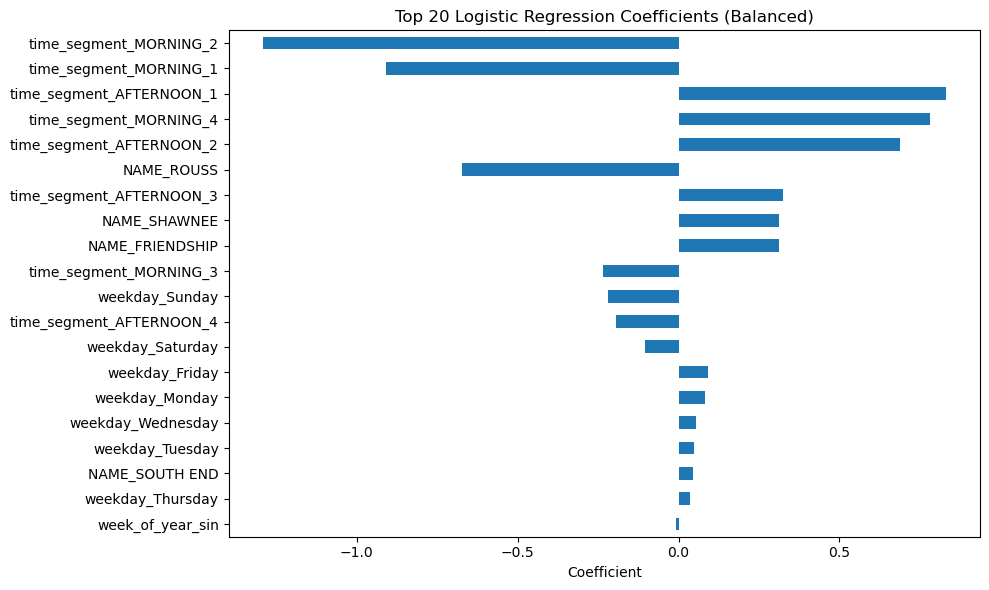

In [5]:
print("""
      \n\n
      ____________________________________________________________________________________
      Logistic Regression
      ____________________________________________________________________________________
      \n\n
      """
      )
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

# Prediction
y_val_pred_lr = lr.predict(X_val)
y_test_pred_lr = lr.predict(X_test)

# Evaluation
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred_lr))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_lr))

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred_lr))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_lr))

# Feature Importance
lr_coefs = pd.Series(lr.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
print("\nTop 20 Logistic Regression Features:")
print(lr_coefs.head(20))

# Plot top 20 most important features
plt.figure(figsize=(10, 6))
lr_coefs.head(20).plot(kind='barh')
plt.title("Top 20 Logistic Regression Coefficients (Balanced)")
plt.xlabel("Coefficient")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


      


      ____________________________________________________________________________________
      Random Forest
      ____________________________________________________________________________________
      


      

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     22134
           1       0.16      0.03      0.05      1610

    accuracy                           0.92     23744
   macro avg       0.55      0.51      0.51     23744
weighted avg       0.88      0.92      0.90     23744

Validation Confusion Matrix:
[[21878   256]
 [ 1562    48]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     22134
           1       0.17      0.03      0.05      1610

    accuracy                           0.92     23744
   macro avg       0.55      0.51      0.51     23744
weighted avg       0.88      0.92      0.90     2

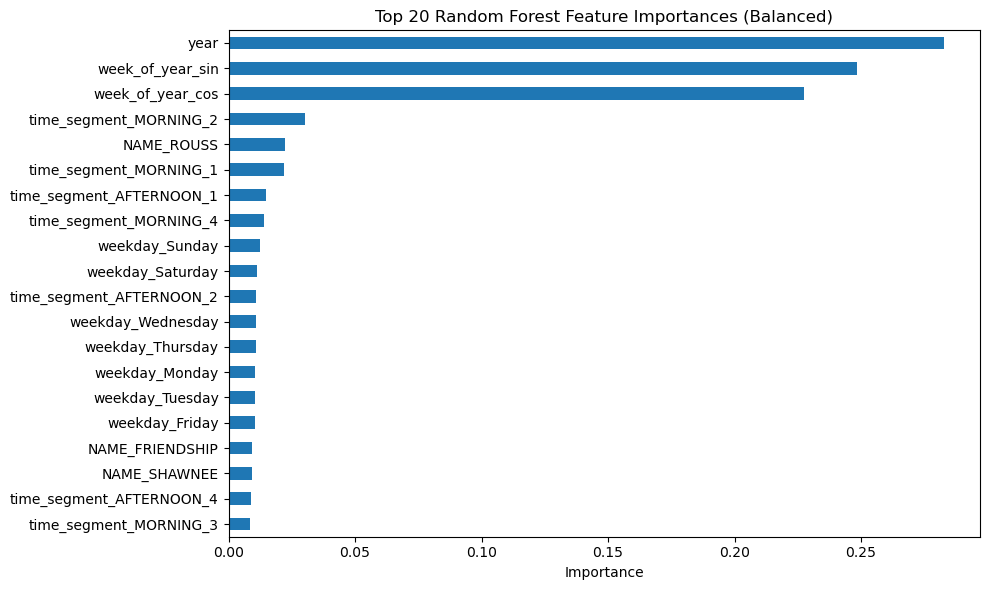

In [6]:
print("""
      \n\n
      ____________________________________________________________________________________
      Random Forest
      ____________________________________________________________________________________
      \n\n
      """
      )
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Predict
y_val_pred_rf = rf.predict(X_val)
y_test_pred_rf = rf.predict(X_test)

# Evaluation
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred_rf))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_rf))

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred_rf))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_rf))

# Feature importance
rf_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 20 Random Forest Features:")
print(rf_importance.head(20))

# Plot top 20 most important features
plt.figure(figsize=(10, 6))
rf_importance.head(20).plot(kind='barh')
plt.title("Top 20 Random Forest Feature Importances (Balanced)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()